# Rigorous Thermodynamic Decomposition of Salt Effects on the Polymerization of Polyethylene Glycol
Stefan Hervø-Hansen<sup>a,*</sup>, Jan Heyda<sup>b,*</sup>, and Nobuyuki Matubayasi<sup>a,*</sup>.<br><br>
<sup>a</sup> Division of Chemical Engineering, Graduate School of Engineering Science, Osaka University, Toyonaka, Osaka 560-8531, Japan.<br>
<sup>b</sup> Department of Physical Chemistry, University of Chemistry and Technology, Prague CZ-16628, Czech Republic.<br>
<sup>*</sup> To whom correspondence may be addressed: stefan@cheng.es.osaka-u.ac.jp, heydaj@vscht.cz, and nobuyuki@cheng.es.osaka-u.ac.jp.

## Part 2: Analysis


### Introduction


### Methods & Materials
Molecular dynamics simulations are conducted using the openMM (7.7.0)[<sup>1</sup>](#fn1) software package modded with the parmed[<sup>2</sup>](#fn2) package and be found in the [Part 1 Jupyter notebook](Simulations.ipynb). For the simulation of PEG a CHARMM derived force field (C35r) was utilized, which has previously been able to reproduce hydrodynamic radii and shape anisotropy of PEG.[<sup>3</sup>](#fn3) The PEG force field was employed in combination with the SPC/E force field for water[<sup>4</sup>](#fn4) and optimized ion parameters for sodium thiocyanate and sodium chloride.[<sup>5,</sup>](#fn5)[<sup>6</sup>](#fn6)
The isothermal-isobaric ensemble will be sampled using a combination of a "Middle" discretization Langevin leap-frog integrator[<sup>7</sup>](#fn7) and a Monte Carlo barostat[<sup>8,</sup>](#fn8)[<sup>9</sup>](#fn9). The trajectories was analyzed using MDtraj[<sup>10</sup>](#fn10) for structural properties, while ERmod[<sup>11</sup>](#fn11) be utilized for the calculation of solvation free energies and can be found in the [Part 2 Jupyter notebook](Analysis.ipynb).

### References
1. <span id="fn1"> P. Eastman, et al., OpenMM 7: Rapid development of high performance algorithms for molecular dynamics. PLoS Comput Biol 13, e1005659 (2017).</span><br>
2. <span id="fn2"> https://github.com/ParmEd/ParmEd </span><br>
3. <span id="fn3"> H. Lee, R. M. Venable, A. D. MacKerell Jr., R. W. Pastor, Molecular Dynamics Studies of Polyethylene Oxide and Polyethylene Glycol: Hydrodynamic Radius and Shape Anisotropy. Biophysical Journal 95, 1590–1599 (2008). </span><br>
4. <span id="fn4"> H. J. C. Berendsen, J. R. Grigera, T. P. Straatsma, The missing term in effective pair potentials. J. Phys. Chem. 91, 6269–6271 (1987). </span><br>
5. <span id="fn5"> T. Křížek, et al., Electrophoretic mobilities of neutral analytes and electroosmotic flow markers in aqueous solutions of Hofmeister salts. ELECTROPHORESIS 35, 617–624 (2014). </span><br>
6. <span id="fn6"> J. Heyda, J. C. Vincent, D. J. Tobias, J. Dzubiella, P. Jungwirth, Ion Specificity at the Peptide Bond: Molecular Dynamics Simulations of N-Methylacetamide in Aqueous Salt Solutions. J. Phys. Chem. B 114, 1213–1220 (2009). </span><br>
7. <span id="fn7"> Z. Zhang, X. Liu, K. Yan, M. E. Tuckerman, J. Liu, Unified Efficient Thermostat Scheme for the Canonical Ensemble with Holonomic or Isokinetic Constraints via Molecular Dynamics. J. Phys. Chem. A 123, 6056–6079 (2019). </span><br>
8. <span id="fn8"> K.-H. Chow, D. M. Ferguson, Isothermal-isobaric molecular dynamics simulations with Monte Carlo volume sampling. Computer Physics Communications 91, 283–289 (1995). </span><br>
9. <span id="fn9"> J. Åqvist, P. Wennerström, M. Nervall, S. Bjelic, B. O. Brandsdal, Molecular dynamics simulations of water and biomolecules with a Monte Carlo constant pressure algorithm. Chemical Physics Letters 384, 288–294 (2004). </span><br>
10. <span id="fn10"> R. T. McGibbon, et al., MDTraj: A Modern Open Library for the Analysis of Molecular Dynamics Trajectories. Biophysical Journal 109, 1528–1532 (2015) </span><br>
11. <span id="fn11"> S. Sakuraba, N. Matubayasi, Ermod: Fast and versatile computation software for solvation free energy with approximate theory of solutions. J. Comput. Chem. 35, 1592–1608 (2014). </span><br>


## Import of Python Modules & Auxiliary Functions

In [2]:
#Notebook dependent libs
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import mdtraj as md
import parmed as pmd
import os, time, re, yaml, string
import scipy.stats as stats
from uncertainties import unumpy

from Auxiliary import fessa
plt.set_cmap('fessa')

kcal_to_kT = 1.688 # Assuming 298.15 K

ERMODHOME = '/work/ERCINCR/stefan/ermod-0.3.7'
homedir = !pwd
homedir = homedir[0]
print(homedir)

/work/1/ERCINCR/stefan/PEO-Solubility


<Figure size 432x288 with 0 Axes>

### Simulation settings

In [3]:
# State of simulations, (outFreq is steps per frame)
states = {                                                               
          'sol': {'Nsteps': 50000000, 'OutFreq': 2500, 'DO_SIMULATED_TEMPERING': False}, # 200 nanoseconds, 20000 frames
          'ref': {'Nsteps': 12500000, 'OutFreq': 2500, 'DO_SIMULATED_TEMPERING': False}, # 50 nanoseconds,   5000 frames
         }


# Simulated Tempering Settings
ST_settings = {'numTemperatures': 15,        # Number of temperatures with exponential spacing
               'minTemperature': 298.15,     # Minimum temperature. cf. Langevin integrator temperature
               'maxTemperature': 450,        # Maximum temperature. Aim to unfold PEO
               'reportInterval': 2500,       # Reporting interval of weights and temperature.
               'reportFile': 'Tempering.dat' # Name of the file where the data are stores.
              }

nmers = [2, 4, 6, 8, 15, 36]

salts = {
         'No_salt': {'Cation': 'No_', 'Anion': 'salt' },
#         'NaCl'   : {'Cation': 'Na' , 'Anion': 'Cl'   },
#         'CsCl'   : {'Cation': 'Cs' , 'Anion': 'Cl'   },
         'NaSCN'  : {'Cation': 'Na' , 'Anion': 'SCN'  },
#         'CsSCN'  : {'Cation': 'Cs' , 'Anion': 'SCN'  },
        }

# Approximate concentrations of salts with
concentrations = {
#                  0.00: {'PEG': 1, 'Water': 10000, 'Cation': 0,   'Anion': 0},
                  1.00: {'PEG': 1, 'Water': 10000, 'Cation': 109, 'Anion': 109},
#                  2.00: {'PEG': 1, 'Water': 10000, 'Cation': 218, 'Anion': 218},
                 }

#* Calculated by hand *#
# Cube length ≈ 66.95 Ångstroms. Round up to 70 Å and then adjust to correct volume with barostat.

## Analysis
### Prepare ERmod analysis
<img style="float: right;width:319.5px;height:312.5px;" src="Figures/ermod.png" title="ERmod analysis flow" />

The determination of solvation free energies and chemical potentials though the ERmod software is conducted in two stages as illustrated in the figure. First is the determination of the energy distribution functions from the simulation trajectories obtained from molecular dynamics using the subprogram `ermod`. Second is the solvation free energy is determined from the energy distribution functions though an approximate functional using the subprogram `slvfe`.

Documentation for the parameter file `parameters_er` which determines how the `ermod` subprogram runs can be found [here](https://sourceforge.net/p/ermod/wiki/parameters-ermod03/). In the python code below it can be noted many of the parameters has been given the keyword `[correct]`, these settings are dependent on the simulation settings and or the software being used and are thus recommended not to be changed if using the openMM setup above. The parameters given the keyword `[to be set]` are settings either collected from the output of the openMM script or set by the user, in specific the values for `maxins` and `engdiv` should be given by the user are given the default value of 1000 and 5 respectively.

Documentation for the parameter file `parameters_fe` which determines how the `slvfe` subprogram runs can be found [here](https://sourceforge.net/p/ermod/wiki/parameters-slvfe/). It is recommended not to change the parameters in this file with the exception of the temperature if conducting simulations at other temperatures than 298.15 Kelvin, and the volume. In the code below the average volume input is calculated as an average volume from the two ensemble volume averages.

In [ ]:
# ERmod settings
state_parameters = {
    'refs': {'state': 3, 'Ninserts': 200, 'Ndivisions': 5},
    'soln': {'state': 1, 'Ninserts': 200, 'Ndivisions': 10}
}
confEnsemble = 'solvated'   # Select the conformational ensemble to be inserted: 'solvated' or 'vacuum'

ermod_script = """
&ene_param
      slttype = {state},     ! Choose system; 1: Solution system  2,3: Reference                     [to be set]
      boxshp = 1,            ! Boxtype                                                               [correct]   
      estype = 2,            ! Ensemble; 1: NVT   2: NPT                                             [correct]   
      inptemp = 298.15,      ! Temperature (in Kelvin)                                               [correct]   
      ljformat = 5,          ! LJ form                                                               [correct]   
      cmbrule = 1,           ! Combination rule                                                      [correct]   
      ljswitch = 1,          ! Switching function for smooth LJ truncation                           [correct]   
      upljcut = 12,          ! Upper limit for LJ cutoff switching function (in Angstrom)            [correct]   
      lwljcut = 10,          ! Lower limit for LJ cutoff switching function (in Angstrom)            [correct]   
      cltype = 2,            ! Treatment of Coulomb interaction (2=PME)                              [correct]   
      elecut = 12.0,         ! Cutoff of the real-space electrostatic interaction (in angstrom)      [correct]   
      ewtoler = 0.00001,     ! Error tolerance in Ewald                                              [correct]   
      splodr = 5,            ! Order of spline function used in PME                                  [correct]   
      ms1max = {PMEnodes_x}, ! Number of meshes in PME (x)                                           [to be set] 
      ms2max = {PMEnodes_y}, ! Number of meshes in PME (y)                                           [to be set] 
      ms3max = {PMEnodes_z}, ! Number of meshes in PME (z)                                           [to be set] 
      maxins = {Ninserts},   ! Number of inserts (chosen freely, for reference ONLY)                 [to be set] 
      engdiv = {Ndivisions}, ! Number of divisions of the total simulation length (chosen freely)    [to be set] 
/
&hist
      eclbin=5.0e-2, ecfbin=2.0e-3, ec0bin=2.0e-4, finfac=10.0e0,
      ecdmin=-150.00, ecfmns=-0.20e0, ecdcen=0.0e0, eccore=50.0e0,
      ecdmax=1.0e11, pecore=200
/
"""
    
slvfe_script = """
&fevars
clcond    = "merge",       ! Calculation type, "merge" / "basic" / "range"
numsln    = {Nsol_blocks}, ! Number of trajectory blocks in solution system
numref    = {Nref_blocks}, ! Number of trajectory blocks in reference system
numdiv    = {Nsol_blocks}, ! Number of division for statistics, usually set equal to numsln
avevolume = {avgV},        ! Average volume sampled in simulation (in Angstrom^3)

ljlrc     = 'yes',         ! Long-range correction of the Lennard-Jones interaction (avevolume must be specified)
uvread    = "yes",         ! "not" if average solute-solvent energy is calculated from engsln, instead of aveuv.tt
slfslt    = "yes",         ! "not" if the solute self energy is not read
infchk    = "yes",         ! Enable error analysis for the logarithmic-mesh part
inptemp   = 298.15,        ! Input Temperature in Kelvin
cumuint   = 'yes',         ! Enable running integral calculations.
/
"""

### Generate ERmod Files
The following cell is fairly complicated and uses a mix of bash and python. While ERmod provides tools to assist in the construction of input files based on many popular molecular dynamics packages log files openMM is still yet to be supported. In the following we manually create the files. The steps are as follow:
1. Use the ERmod's `gen_structure` script to generate non-complete input scripts as well as the folders `refs` and `soln` containing pair-energy distributions at $\lambda=0$ and $\lambda=1$ respectively.
2. For soln and refs: Construct a `parameter_er` file as previously described, with updated PME parameters.
3. For soln and refs: Edit the MDinfo file containing the number of frames in the solution and reference state.
4. For soln and refs: Create a symlink named `HISTORY` linking to the joint trajectory for the solution and reference state.
5. For refs: Create a symlink named `SltConf` linking to the isolated trajectory of PEO. The conformational enemble of PEO can be controlled with the parameter `confEnsemble` taking the values `solvated` or `vacuum`.
6. Create the `parameters_fe` file with the main edit being the average volume sampled at $\lambda=1$ for long-range correction of Lennard-Jones interactions.

In [ ]:
%cd -q $homedir
for nmer in nmers:
    nmerdir = 'PEG{}mer'.format(nmer)
    for saltdir, salt in salts.items():
        for conc, Nparticles in concentrations.items():
            concdir = '{0:.2f}'.format(conc)
            if conc == 0 and saltdir == 'No_salt':
                WORKDIR = '{homedir}/Simulations/{nmerdir}/{saltdir}'.format(homedir=homedir, nmerdir=nmerdir, saltdir=saltdir)
            elif conc != 0 and saltdir == 'No_salt':
                continue
            else:
                WORKDIR = '{homedir}/Simulations/{nmerdir}/{saltdir}/{concdir}'.format(homedir=homedir, nmerdir=nmerdir, saltdir=saltdir, concdir=concdir)
            %cd -q $WORKDIR
            
            topname = 'PEG_{nmer}_{salt}_hydrated_sol.parm7'.format(nmer=nmer, salt=saltdir)
            !echo 1 | /usr/bin/python2 $ERMODHOME/tools/AMBER/gen_structure --top $topname
            
            PEG = pmd.load_file('PEG_{nmer}_{salt}_hydrated_sol.pdb'.format(nmer=nmer, salt=saltdir))
            PEG.strip(':HOH')

            #########
            # ERMOD #
            #########
            for ermodstate in ['soln', 'refs']:
                %cd -q $WORKDIR/$ermodstate
        
                with open('../run_{}.out'.format(ermodstate[:3]), 'r') as logfile:
                    lines = logfile.readlines()
                logfile.close()
                index = [idx for idx, s in enumerate(lines) if 'PARTICLE MESH EWALD PARAMETERS' in s][0]
                PME_spacing = re.findall("([0-9]+[,.]+[0-9]+)", lines[index+1])
                N_gridpoints = (*re.findall("([0-9]+)", lines[index+2]),
                                *re.findall("([0-9]+)", lines[index+3]),
                                *re.findall("([0-9]+)", lines[index+4]))
        
                parameters = state_parameters[ermodstate]
                with open('parameters_er', 'w') as f:
                    f.write(ermod_script.format(state=parameters['state'], Ninserts=parameters['Ninserts'], Ndivisions=parameters['Ndivisions'],
                                                PMEnodes_x=N_gridpoints[0], PMEnodes_y=N_gridpoints[1], PMEnodes_z=N_gridpoints[2]))
        
                with open('MDinfo', 'r+') as f:
                    lines = f.readlines()
                    num_frames =  int(states[ermodstate[:3]]['Nsteps']/states[ermodstate[:3]]['OutFreq'])
                    lines[0] = lines[0].replace('FRAMES', str(num_frames))
                    f.seek(0)
                    f.truncate()
                    for line in lines:
                        f.write(line)
                f.close()
                
                with open('SltAtomGroup', 'w') as f:
                    for residue in PEG.residues:
                        indexes = []
                        for atom in residue.atoms:
                            indexes.append(atom.idx+1)
                        f.write(" ".join(map(str, indexes))+'\n')
                f.close()
        
                trajname = 'trajectory_{}.xtc'.format(ermodstate[:3])
                !ln -s $WORKDIR/$trajname HISTORY
        
                if ermodstate == 'soln':
                    traj = md.load_xtc('../{}'.format(trajname),
                                       top='../PEG_{nmer}_{salt}_hydrated_sol.pdb'.format(nmer=nmer, salt=saltdir),
                                       stride=200)
                    atom_indices = traj.topology.select('resname PGH or resname PGM or resname PGT')
                    traj.atom_slice(atom_indices, inplace=True)
                    traj.save_xtc('../trajectory_sol_striped.xtc', force_overwrite=True)
                if ermodstate == 'refs':
                    if confEnsemble == 'solvated':
                        !ln -s $WORKDIR/trajectory_sol_striped.xtc SltConf
                    elif confEnsemble == 'vacuum':
                        !ln -s $WORKDIR/../Solute/trajectory.xtc SltConf
                    else:
                        raise Exception("ERROR:`confEnsemble` must be either 'solvated' or 'vacuum'")
            
            #########
            # SLVFE #
            #########
            %cd -q $WORKDIR
            vol_data = np.loadtxt('output_ref.dat', usecols=4, skiprows=1)
            avgVolume = vol_data.mean()*1000
            with open('parameters_fe', 'w') as f:
                f.write(slvfe_script.format(Nsol_blocks=state_parameters['soln']['Ndivisions'],
                                        Nref_blocks=state_parameters['refs']['Ndivisions'],
                                        avgV=avgVolume))
            print('Wrote ERmod analysis files to '+os.getcwd())

### Submit ERmod analysis
Submit script for servers employing job scheduling. The below example is utilizing PBS (for a quick guide see [here](https://latisresearch.umn.edu/creating-a-PBS-script)). However the code below may be edited to utilize Slurm instead (documentation [here](https://slurm.schedmd.com)) by changing the variable `submit_script` and by executing the commands `!sbatch submit_ermod.pbs` instead of `qsub`.

In [ ]:
submit_script="""#!/bin/bash
#PBS -A ERCINCR             # Account
#PBS -q gen_S               # Queue
#PBS -b 1                   # 1 node
#PBS -N ermod_{name}        # Job name
#PBS -e ermod.err           # Error output
#PBS -o ermod.out           # Output file name

source ~/.bashrc
source ~/.bash_profile

export ERMOD=/work/ERCINCR/stefan/ermod-0.3.7
export ERMOD_PLUGINS=/work/ERCINCR/stefan/ermod-0.3.7/vmdplugins/libexec

PATH=$PATH:/work/ERCINCR/stefan/ermod-0.3.7
export PATH

sleep 13

cd {path}

# Calculate solvation energy
# Solution step
cd soln
mpirun -np 24 ermod
cd ..

# Reference step
cd refs
mpirun -np 24 ermod
cd ..

slvfe
"""

%cd -q $homedir
for nmer in nmers:
    nmerdir = 'PEG{}mer'.format(nmer)
    for saltdir, salt in salts.items():
        for conc, Nparticles in concentrations.items():
            concdir = '{0:.2f}'.format(conc)
            if conc == 0 and saltdir == 'No_salt':
                WORKDIR = '{homedir}/Simulations/{nmerdir}/{saltdir}'.format(homedir=homedir, nmerdir=nmerdir, saltdir=saltdir)
            elif conc != 0 and saltdir == 'No_salt':
                continue
            else:
                WORKDIR = '{homedir}/Simulations/{nmerdir}/{saltdir}/{concdir}'.format(homedir=homedir, nmerdir=nmerdir, saltdir=saltdir, concdir=concdir)
            %cd -q $WORKDIR
            
            name = 'ERMOD_{}_{}_{}'.format(nmerdir, saltdir, concdir)
            with open('submit_ermod.pbs', 'w') as text_file:
                text_file.write(submit_script.format(path=WORKDIR, name=name))
            !qsub submit_ermod.pbs
            time.sleep(1)

## Solvation Free Energies: Effect of PEO Polymerization
We will start the analysis by visualizing the trend of the solvation free energy against the polymer length of PEO in water. This is to establish if a possible regression model can be used later on to analyze the effect of salt. The solvation free energies from ERmod are stored in the files named `ermod.out` and be found in the various simulation directories.

### Polyethylene glycol solvation energy and polymer length in water

Linear statistics:
Slope: -2.992 ± 0.008 kcal/mol/monomer.
Intercept: 1.454 ± 0.137 kcal/mol.
R²: 1.0000
p-value: 3.537056e-10


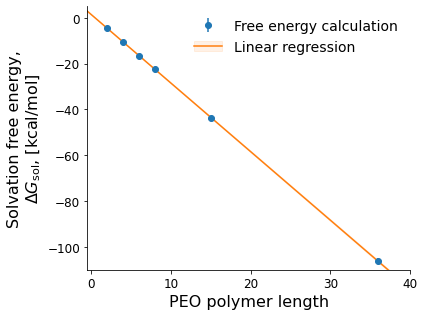

In [4]:
%cd -q $homedir
fig, ax = plt.subplots(figsize=(6,4.5))

slvfe = []
slvfe_err = []

for nmer in nmers:
    with open('Simulations/PEG{}mer/No_salt/ermod.out'.format(nmer)) as f:
        lines = f.readlines()
    f.close()
    for lineNR, line in enumerate(lines):
        if "cumulative average & 95% error for solvation free energy" in line:
            slvfe.append(float(lines[lineNR+10].split()[1]))
            slvfe_err.append(float(lines[lineNR+10].split()[2]))
            break        

sims = ax.errorbar(nmers, slvfe, yerr=slvfe_err, marker='o', linestyle='None', color='C0')

ax.set_xlabel('PEO polymer length', fontsize=16)
ax.set_ylabel('Solvation free energy,\n$\Delta G_{\mathrm{sol}}$, [kcal/mol]', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

s = stats.linregress(np.array(nmers), slvfe)
print('Linear statistics:\nSlope: {:.3f} ± {:.3f} kcal/mol.\nIntercept: {:.3f} ± {:.3f} kcal/mol.\nR²: {:.4f}\np-value: {:e}'.format(s.slope, s.stderr, s.intercept, s.intercept_stderr, s.rvalue**2, s.pvalue))
linregress = ax.plot(np.arange(-1, 50, 0.1), s.intercept+np.arange(-1, 50, 0.1)*s.slope, 'C1')
linregress_err = ax.fill_between(np.arange(-1, 50, 0.1), y1=(s.intercept+s.intercept_stderr)+np.arange(-1, 50, 0.1)*(s.slope+s.stderr),
                                                        y2=(s.intercept-s.intercept_stderr)+np.arange(-1, 50, 0.1)*(s.slope-s.stderr),
                             color='C1', alpha=0.1)

leg = ax.legend([sims, (linregress[0], linregress_err)], ['Free energy calculation', 'Linear regression'],
                loc='upper right', frameon=False, fontsize=14)

ax.set_xlim(-0.5, 40)
ax.set_ylim(-110, 5)

fig.tight_layout()
fig.savefig('Figures/PEG_polymerlength.pdf', bbox_inches='tight')

From the figure above it is clear that the solvation free energy varies linearly with the PEO polymer length. Given this knowledge, we can plot the solvation free energy of PEG against the PEO polymer length in the presence of sodium thiocyanate and sodium chloride.

### Polyethylene glycol solvation energy and polymer length in salt

Linear statistics: No_salt
    Slope: -2.992 ± 0.008 kcal/mol/monomer.
    Intercept: 1.454 ± 0.137 kcal/mol.
    R²: 1.0000
    p-value: 3.537056e-10

Linear statistics: NaSCN/1.00
    Slope: -2.986 ± 0.020 kcal/mol/monomer.
    Intercept: 1.444 ± 0.325 kcal/mol.
    R²: 0.9998
    p-value: 1.118927e-08



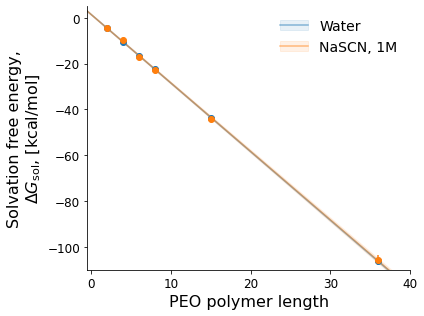

In [5]:
%cd -q $homedir
fig, ax = plt.subplots(figsize=(6,4.5))
icons = []

for i, condition in enumerate(['No_salt', 'NaSCN/1.00', 'NaCl/1.00']):
    slvfe = []
    slvfe_err = []
    for nmer in nmers:
        with open('Simulations/PEG{}mer/{}/ermod.out'.format(nmer, condition)) as f:
            lines = f.readlines()
        f.close()
        for lineNR, line in enumerate(lines):
            if "cumulative average & 95% error for solvation free energy" in line:
                slvfe.append(float(lines[lineNR+10].split()[1]))
                slvfe_err.append(float(lines[lineNR+10].split()[2]))
                break
    ax.errorbar(nmers, slvfe, yerr=slvfe_err, marker='o', linestyle='None', color='C'+str(i))
    s = stats.linregress(nmers, slvfe)
    linregress = ax.plot(np.arange(-1, 50, 0.1), s.intercept+np.arange(-1, 50, 0.1)*s.slope, color='C'+str(i), alpha=0.5)
    linregress_err = ax.fill_between(np.arange(-1, 50, 0.1),
                                     y1=(s.intercept+s.intercept_stderr)+np.arange(-1, 50, 0.1)*(s.slope+s.stderr),
                                     y2=(s.intercept-s.intercept_stderr)+np.arange(-1, 50, 0.1)*(s.slope-s.stderr),
                                     color='C'+str(i), alpha=0.1)
    
    print('''Linear statistics: {}
    Slope: {:.3f} ± {:.3f} kcal/mol/monomer.
    Intercept: {:.3f} ± {:.3f} kcal/mol.
    R²: {:.4f}
    p-value: {:e}\n'''.format(condition, s.slope, s.stderr, s.intercept, s.intercept_stderr, s.rvalue**2, s.pvalue))
    icons.append((linregress[0],linregress_err))
    

leg = ax.legend(icons, ['Water', 'NaSCN, 1M', 'NaCl, 1M'],
                loc='upper right', frameon=False, fontsize=14)

ax.set_xlabel('PEO polymer length', fontsize=16)
ax.set_ylabel('Solvation free energy,\n$\Delta G_{\mathrm{sol}}$, [kcal/mol]', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlim(-0.5, 40)
ax.set_ylim(-110, 5)

fig.tight_layout()
fig.savefig('Figures/PEG_polymerlength_salt.pdf', bbox_inches='tight')

It can be observed that the addition of salt still causes the solvation free energy to vary linearly with the PEO polymer length. Furthermore, it is clear that the perturbation by salt is fairly small and thus indicates the importance of errors to separate salt effects from statistical noise.

To quantify the change of salt on the solvation free energy per monomer we define the difference in solvation free energy per monomer as:
$$
\Delta \Delta G_{\mathrm{sol,Monomer}} = \frac{\Delta G_{\mathrm{sol}}(C_{\mathrm{salt}}) - \Delta G_{\mathrm{sol}}(0)}{N_{\mathrm{PEO}}}
$$
Below the difference in solvation free energy per monomer is visualized as a function of the PEO polymer length.

### Difference in solvation free energy per monomer upon addition of salt

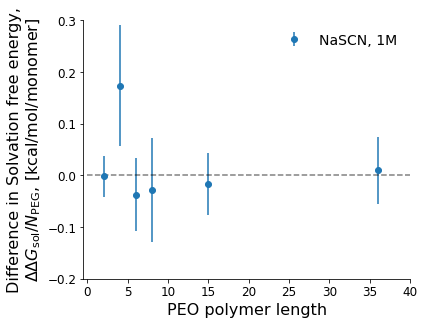

In [6]:
%cd -q $homedir
fig, ax = plt.subplots(figsize=(6,4.5))
icons = []

# Water
slvfe_wat = []
slvfe_wat_err = []
for nmer in nmers:
    with open('Simulations/PEG{}mer/No_salt/ermod.out'.format(nmer)) as f:
        lines = f.readlines()
    f.close()
    for lineNR, line in enumerate(lines):
        if "cumulative average & 95% error for solvation free energy" in line:
            slvfe_wat.append(float(lines[lineNR+10].split()[1]))
            slvfe_wat_err.append(float(lines[lineNR+10].split()[2]))
            break
slvfe_wat = unumpy.uarray(slvfe_wat, slvfe_wat_err)

# Non-water conditions
for i, condition in enumerate(['NaSCN/1.00', 'NaCl/1.00']):
    slvfe = []
    slvfe_err = []
    for nmer in nmers:
        with open('Simulations/PEG{}mer/{}/ermod.out'.format(nmer, condition)) as f:
            lines = f.readlines()
        f.close()
        for lineNR, line in enumerate(lines):
            if "cumulative average & 95% error for solvation free energy" in line:
                slvfe.append(float(lines[lineNR+10].split()[1]))
                slvfe_err.append(float(lines[lineNR+10].split()[2]))
                break
    slvfe = unumpy.uarray(slvfe, slvfe_err)
    dslvfe = (slvfe - slvfe_wat)/np.array(nmers)

    errplt = ax.errorbar(nmers, unumpy.nominal_values(dslvfe), yerr=unumpy.std_devs(dslvfe),
                         marker='o', linestyle='None', color='C'+str(i), alpha=1)
    icons.append(errplt)

ax.hlines(0, xmin=0, xmax=40, colors='black', linestyle='dashed', alpha=0.5)

leg = ax.legend(icons, ['NaSCN, 1M', 'NaCl, 1M'],
                loc='upper right', frameon=False, fontsize=14)

ax.set_xlabel('PEO polymer length', fontsize=16)
ax.set_ylabel('Difference in Solvation free energy,\n$\Delta\Delta G_{\mathrm{sol}}/N_{\mathrm{PEG}}$, [kcal/mol/monomer]', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlim(-0.5, 40)
ax.set_ylim(-0.2, 0.3)

fig.tight_layout()
fig.savefig('Figures/PEG_polymerlength_salt_difference.pdf', bbox_inches='tight')

Normalizing the difference in solvation free energy upon the addition of salt by $N_{\mathrm{PEO}}$. An alternative, and perhaps more suitable normalization, is to normalize the solvation free energy by the solvent-accessible surface area (SASA) of PEG. We define the difference in solvation free energy per SASA as:
$$
\Delta \Delta G_{\mathrm{sol,SASA}} = \frac{\Delta G_{\mathrm{sol}}(C_{\mathrm{salt}})}{\langle\mathrm{SASA}_{\mathrm{PEO, salt}}\rangle} - \frac{\Delta G_{\mathrm{sol}}(0)}{\langle\mathrm{SASA}_{\mathrm{PEO, water}}\rangle}
$$
Where the SASA is taken as the ensemble average. The SASA of PEO for the individual frames is calculated via the Shrake & Rupley (rolling ball) algorithm. Below the difference in solvation free energy per SASA is visualized as a function of the PEO polymer length.

### Difference in solvation free energy per SASA upon addition of salt

Finished PEG2
Finished PEG4
Finished PEG6
Finished PEG8
Finished PEG15
Finished PEG36


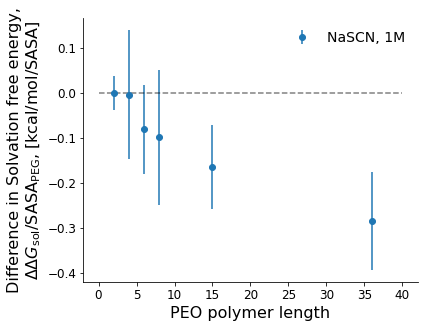

In [7]:
fig, ax = plt.subplots(figsize=(6,4.5))
icons = []

conditions = ['No_salt', 'NaSCN/1.00', 'NaCl/1.00']

slvfe = np.zeros(shape=(len(nmers), len(salts)))
slvfe_err = np.zeros(shape=(len(nmers), len(salts)))

for i, nmer in enumerate(nmers):
    pdb = md.load_pdb('Simulations/PEG{nmer}mer/NaSCN/1.00/PEG_{nmer}_NaSCN_hydrated_sol.pdb'.format(nmer=nmer))
    PEG_indices = pdb.topology.select('(resname PGH) or (resname PGM) or (resname PGT)')
    
    for j, condition in enumerate(conditions):
        traj = md.load_xtc('Simulations/PEG{}mer/{}/trajectory_sol.xtc'.format(nmer, condition),
                           top='PDB_files/PEO-{}-mer.pdb'.format(nmer), atom_indices=PEG_indices)
        sasa = md.shrake_rupley(traj, mode='residue') # SASA calculation can be a bit slow...
        
        with open('Simulations/PEG{}mer/NaSCN/1.00/ermod.out'.format(nmer)) as f:
            lines = f.readlines()
        f.close()
        for lineNR, line in enumerate(lines):
            if "cumulative average & 95% error for solvation free energy" in line:
                slvfe[i][j] = float(lines[lineNR+10].split()[1]) / sasa.sum(axis=1).mean()
                slvfe_err[i][j] = float(lines[lineNR+10].split()[2]) / sasa.sum(axis=1).mean()
                break
    print('Finished PEG{}'.format(nmer))
                        
slvfe = unumpy.uarray(slvfe, slvfe_err)

# Get to plotting...
for i in range(1,len(conditions)):
    dslvfe = slvfe[:,i] - slvfe[:,0]
    errplt = ax.errorbar(nmers, unumpy.nominal_values(dslvfe), yerr=unumpy.std_devs(dslvfe),
                         marker='o', linestyle='None', color='C{}'.format(i-1), alpha=1)
    icons.append(errplt)
    
ax.hlines(0, xmin=0, xmax=40, colors='black', linestyle='dashed', alpha=0.5)
leg = ax.legend(icons, ['NaSCN, 1M', 'NaCl, 1M'],
                loc='upper right', frameon=False, fontsize=14)

ax.set_xlabel('PEO polymer length', fontsize=16)
ax.set_ylabel('Difference in Solvation free energy,\n$\Delta\Delta G_{\mathrm{sol}}/\mathrm{SASA}_{\mathrm{PEG}}$, [kcal/mol/SASA]', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.tight_layout()
fig.savefig('Figures/PEG_polymerlength_salt_difference_SASA_scaled.pdf', bbox_inches='tight')

From the figure above a trend is emerging revealing NaSCN is affecting PEO with increasing PEO polymer length. To understand the perturbation in SASA upon the addition of salt, the SASA probability distribution functions are visualized below.

### SASA of PEO histograms in pure water and salt solutions

Finished PEG2
Finished PEG4
Finished PEG6
Finished PEG8
Finished PEG15
Finished PEG36


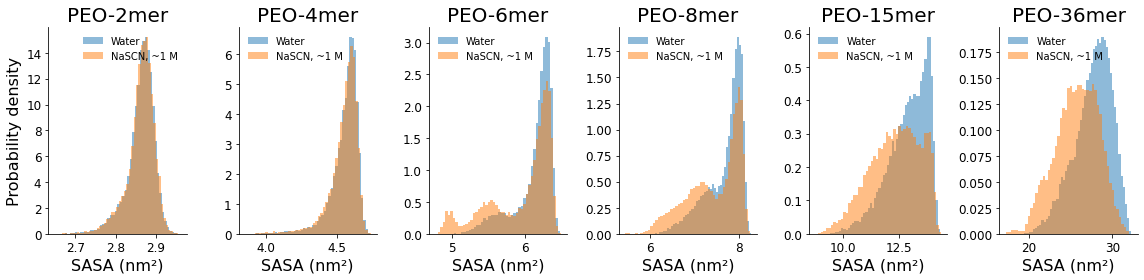

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(16,4))

for i, nmer in enumerate(nmers):
    pdb = md.load_pdb('Simulations/PEG{nmer}mer/NaSCN/1.00/PEG_{nmer}_NaSCN_hydrated_sol.pdb'.format(nmer=nmer))
    PEG_indices = pdb.topology.select('(resname PGH) or (resname PGM) or (resname PGT)')
    for j, condition in enumerate(['No_salt', 'NaSCN/1.00', 'NaCl/1.00']):
        traj = md.load_xtc('Simulations/PEG{}mer/{}/trajectory_sol.xtc'.format(nmer, condition),
                           top='PDB_files/PEO-{}-mer.pdb'.format(nmer), atom_indices=PEG_indices)
        sasa = md.shrake_rupley(traj, mode='residue') # SASA calculation can be a bit slow...

        labels = ['Water', 'NaSCN, ~1 M', 'NaCl, ~1 M']
        axes[i].hist(sasa.sum(axis=1), bins=50, color='C'+str(j), alpha=0.5, label=labels[j], density=True)
        
    axes[i].legend(loc=0, frameon=False)
    print('Finished PEG{}'.format(nmer))

for i, ax in enumerate(axes):
    ax.set_xlabel('SASA (nm²)', fontsize=16)
    if i == 0:
        ax.set_ylabel('Probability density', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title('PEO-{}mer'.format(str(nmers[i])), fontsize=18)
    
fig.tight_layout()
fig.savefig('Figures/PEO_histograms_salt.pdf', bbox_inches='tight')

## Solvation Free Energies: Species Decomposition
The solvation free energy within the framework of the energy-representation theory of solvation can be written as
\begin{equation}
    \Delta G_{\mathrm{sol}} = \Delta G_{\mathrm{self}} + \Delta G_{\mathrm{anion}} + \Delta G_{\mathrm{cation}} + \Delta G_{\mathrm{water}},
    \label{eq:SolventDecomposition}
\end{equation}
where the individual terms constitute the chemical species contribution to the solvation free energy of PEO. The contribution from the anions, cations, and water for the various salt solutions and concentrations can be found in the `ermod.out` files in the various directory.

In the following code, we will first inspect the self-energy, being the first term of the previous equation, asserting it to have a minimal contribution to the total solvation free energy. Next, the solvation free energy's variation with PEO length will be investigated.

### Polyethylene glycol self-energy

In [9]:
%cd -q $homedir

selfs = []

for nmer in nmers:
    for saltdir in salts:
        for conc in concentrations:
            concdir = '{0:.2f}'.format(conc)
            if conc == 0 and saltdir == 'No_salt':
                fpath = 'Simulations/PEG{}mer/No_salt/ermod.out'.format(nmer)
            elif conc != 0 and saltdir == 'No_salt':
                continue
            else:
                fpath = 'Simulations/PEG{}mer/{}/{}/ermod.out'.format(nmer, saltdir, concdir)
            
            with open(fpath) as f:
                lines = f.readlines()
            f.close()
    
            for line in lines:
                if "Self-energy of the solute" in line:
                    selfs.append(float(line.split()[5]))

selfs = np.asarray(selfs)
print('Mean self-contribution ranges from {:.3} to {:.3} kcal/mol.'
      .format(selfs.flatten().min(), selfs.flatten().max()))

Mean self-contribution ranges from -0.0002 to 0.0015 kcal/mol.


**TEXT BELOW UNFINISHED AS OF 22/07-2022**

As we can see the self contribution is overall very small and is thus neglectable for the remainder of the analysis upon conducting the species decomposition.

### Solvent decomposition of the solvation free energy of PEO

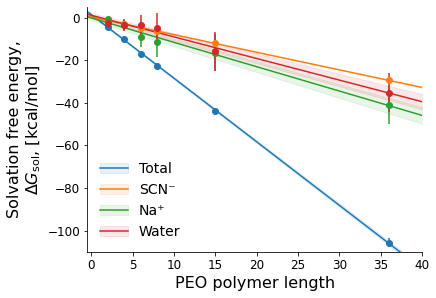

In [10]:
fig, ax = plt.subplots(figsize=(6,4.5))

slvfe_data = np.zeros(shape=(len(nmers), 8))
labels = ['Total', 'SCN⁻', 'Na⁺', 'Water']

for i, nmer in enumerate(nmers):
    with open('Simulations/PEG{}mer/NaSCN/1.00/ermod.out'.format(nmer)) as f:
        lines = f.readlines()
    f.close()
    for lineNR, line in enumerate(lines):
        if "cumulative average & 95% error for solvation free energy" in line:
            data = lines[lineNR+10].split()[1:]
            data = np.array([float(j) for j in data])
            slvfe_data[i] = data

icons = []
for i, species_index in enumerate(range(0, slvfe_data.shape[1], 2)):
    ax.errorbar(nmers, slvfe_data.T[species_index], yerr=slvfe_data.T[species_index+1], label=labels[i], marker='o', linestyle='None',
                color='C'+str(i))
    s = stats.linregress(np.array(nmers), slvfe_data.T[species_index])
    linregress = ax.plot(np.arange(-1, 50, 0.1), s.intercept+np.arange(-1, 50, 0.1)*s.slope, color='C'+str(i))
    linregress_err = ax.fill_between(np.arange(-1, 50, 0.1), y1=(s.intercept+s.intercept_stderr)+np.arange(-1, 50, 0.1)*(s.slope+s.stderr),
                                                        y2=(s.intercept-s.intercept_stderr)+np.arange(-1, 50, 0.1)*(s.slope-s.stderr),
                             color='C'+str(i), alpha=0.1)
    icons.append((linregress[0],linregress_err))
    

leg = ax.legend(icons, labels, loc='best', frameon=False, fontsize=14)

ax.set_xlim(-0.5, 40)
ax.set_ylim(-110, 5)
ax.set_xlabel('PEO polymer length', fontsize=16)
ax.set_ylabel('Solvation free energy,\n$\Delta G_{\mathrm{sol}}$, [kcal/mol]', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


fig.savefig('Figures/PEG_polymerlength_solvent_decomposition.pdf', bbox_inches='tight')

### Species decomposition of the mean solute-solvent interaction variation with salt concentration

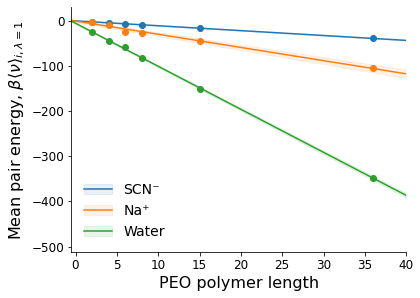

In [11]:
fig, ax = plt.subplots(figsize=(6,4.5))

avguv = np.zeros(shape=(len(nmers), 3))
labels = ['SCN⁻', 'Na⁺', 'Water']

for i, nmer in enumerate(nmers):
    data = np.loadtxt('Simulations/PEG{}mer/NaSCN/1.00/soln/aveuv.tt'.format(nmer),
                      usecols=(1,2,3))
    avguv[i] = data.mean(axis=0)


icons = []
for species_index in range(3):
    ax.plot(nmers, avguv.T[species_index], marker='o', linestyle='None', color='C'+str(species_index))
    s = stats.linregress(np.array(nmers), avguv.T[species_index])
    linregress = ax.plot(np.arange(-1, 50, 0.1), s.intercept+np.arange(-1, 50, 0.1)*s.slope, color='C'+str(species_index))
    linregress_err = ax.fill_between(np.arange(-1, 50, 0.1), y1=(s.intercept+s.intercept_stderr)+np.arange(-1, 50, 0.1)*(s.slope+s.stderr),
                                                        y2=(s.intercept-s.intercept_stderr)+np.arange(-1, 50, 0.1)*(s.slope-s.stderr),
                             color='C'+str(species_index), alpha=0.1)
    icons.append((linregress[0],linregress_err))
    

leg = ax.legend(icons, labels, loc='best', frameon=False, fontsize=14)

ax.set_xlim(-0.5, 40)
#ax.set_ylim(-110, 5)
ax.set_xlabel('PEO polymer length', fontsize=16)
ax.set_ylabel(r'Mean pair energy, $\beta \langle \nu \rangle_{i, \lambda=1}}$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


fig.savefig('Figures/PEG_polymerlength_avguv.pdf', bbox_inches='tight')

# Debuggging

### Radius of Gyration (Conformational ensemble in vacuum and solution)

In [ ]:
fig, axes = plt.subplots(ncols=len(nmers), figsize=(16,3))

bins = np.arange(0, 2, 0.001)

for i, nmer in enumerate(nmers):
    mol = pmd.load_file('Simulations/PEG{nmer}mer/Solute/PEG_{nmer}_vacuum.top'.format(nmer=nmer),
                        xyz='Simulations/PEG{nmer}mer/Solute/PEG_{nmer}_vacuum.pdb'.format(nmer=nmer))
    
    masses = []
    for atom in mol.atoms:
        masses.append(atom.mass)
    
    traj = md.load_xtc('Simulations/PEG{nmer}mer/No_salt/trajectory_sol.xtc'.format(nmer=nmer),
                       top='Simulations/PEG{nmer}mer/No_salt/PEG_{nmer}_No_salt_sol.pdb'.format(nmer=nmer))
    traj.remove_solvent(inplace=True)
    rg = md.compute_rg(traj, masses=np.array(masses))
    solvated_density = axes[i].hist(rg, color='C0', bins=bins)
    
    traj = md.load_xtc('Simulations/PEG{nmer}mer/Solute/trajectory.xtc'.format(nmer=nmer),
                       top='Simulations/PEG{nmer}mer/Solute/PEG_{nmer}_vacuum.pdb'.format(nmer=nmer))
    rg = md.compute_rg(traj, masses=np.array(masses))
    vacuum_density = axes[i].hist(rg, color='C1', bins=bins)
    
    
    axes[i].set_xlabel('Radius of Gyration [nm]')
    shared_density = np.sum(np.minimum(solvated_density[0], vacuum_density[0]))
    axes[i].set_title('Density overlap: {:.2f}%'.format(shared_density/np.sum(np.maximum(solvated_density[0], vacuum_density[0]))*100))

axes[0].set_ylabel('Occurrences')
c0 = mpatches.Patch(color='C0', label='PEG in water')
c1 = mpatches.Patch(color='C1', label='PEG in vaccum')
lgd = fig.legend(handles=[c0, c1], loc='lower center', ncol=2, frameon=False, bbox_to_anchor=(0.5, -0.05))
fig.subplots_adjust(bottom=0.25)

fig.tight_layout()
fig.savefig('Figures/Rg_Soln_Vacuum_ensemble.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

### Radius of Gyration (Conformational ensemble in vacuum and solution)

In [ ]:
mol = pmd.load_file('Simulations/PEG36mer/Solute/PEG_36_vacuum.top',
                    xyz='Simulations/PEG36mer/Solute/PEG_36_vacuum.pdb')
masses = []
for atom in mol.atoms:
    masses.append(atom.mass)
    
    
## TEMPERING ##
traj_tempering = md.load_xtc('Simulations/testing/tempering_test/trajectory_sol.xtc',
                             top='Simulations/testing/tempering_test/PEG_36_No_salt_sol.pdb')
traj_tempering.remove_solvent(inplace=True)
rg_tempering = md.compute_rg(traj_tempering, masses=np.array(masses))

## VACUUM ##
traj_vac = md.load_xtc('Simulations/PEG36mer/Solute/trajectory.xtc', 
                       top='Simulations/PEG36mer/Solute/PEG_36_vacuum.pdb')
rg_vac = md.compute_rg(traj_vac, masses=np.array(masses))

# SOLVATED ##
traj_sol = md.load_xtc('Simulations/PEG36mer/No_salt/trajectory_sol.xtc', 
                       top='Simulations/PEG36mer/No_salt/PEG_36_No_salt_sol.pdb')
traj_sol.remove_solvent(inplace=True)
rg_sol = md.compute_rg(traj_sol, masses=np.array(masses))

In [ ]:
vac_density = plt.hist(rg_vac, bins=100, range=(0.5,2), label='Vacuum')
tem_density = plt.hist(rg_tempering, bins=100, range=(0.5,1.75), label='Tempering')
sol_density = plt.hist(rg_sol, bins=100, range=(0.5,1.75), label='Solvated')
shared_density = np.sum(np.minimum(vac_density[0], tem_density[0]))
print('Shared density: {}%'.format(shared_density/np.sum(np.maximum(vac_density[0], tem_density[0]))*100))
plt.legend(loc=0)
plt.xlim(0.5, 1.7)

In [ ]:
mol = pmd.load_file('Simulations/PEG36mer/Solute/PEG_36_vacuum.top',
                    xyz='Simulations/PEG36mer/Solute/PEG_36_vacuum.pdb')
masses = []
for atom in mol.atoms:
    masses.append(atom.mass)

## 298 Kelvin ##
traj_298 = md.load_xtc('Simulations/PEG36mer/No_salt/trajectory_sol.xtc', 
                       top='Simulations/PEG36mer/No_salt/PEG_36_No_salt_sol.pdb')
traj_298.remove_solvent(inplace=True)
rg_298 = md.compute_rg(traj_298, masses=np.array(masses))

## 600 Kelvin ##
traj_600 = md.load_xtc('Simulations/testing/600_T_test/trajectory_sol.xtc', 
                       top='Simulations/testing/600_T_test/PEG_36_No_salt_sol.pdb')
traj_600.remove_solvent(inplace=True)
rg_600 = md.compute_rg(traj_600, masses=np.array(masses))

## 600 Kelvin ##
traj_1000 = md.load_xtc('Simulations/testing/1000_T_test/trajectory_sol.xtc', 
                        top='Simulations/testing/1000_T_test/PEG_36_No_salt_sol.pdb')
traj_1000.remove_solvent(inplace=True)
rg_1000 = md.compute_rg(traj_1000, masses=np.array(masses))


## VACUUM ##
traj_vac = md.load_xtc('Simulations/PEG36mer/Solute/trajectory.xtc', 
                       top='Simulations/PEG36mer/Solute/PEG_36_vacuum.pdb')
rg_vac = md.compute_rg(traj_vac, masses=np.array(masses))

In [ ]:
density_vac = plt.hist(rg_vac, bins=100, range=(0.5,2), label='Vacuum')
density_298 = plt.hist(rg_298, bins=100, range=(0.5,1.75), label='298.15 Kelvin')
density_600 = plt.hist(rg_600, bins=100, range=(0.5,1.75), label='600 Kelvin')
density_1000 = plt.hist(rg_1000, bins=100, range=(0.5,1.75), label='1000 Kelvin')
plt.legend(loc=0)
plt.xlim(0.5, 1.7)

In [ ]:
mol = pmd.load_file('Simulations/PEG36mer/Solute/PEG_36_vacuum.top',
                    xyz='Simulations/PEG36mer/Solute/PEG_36_vacuum.pdb')
masses = []
for atom in mol.atoms:
    masses.append(atom.mass)
    
## 298 Kelvin ##
traj_298 = md.load_xtc('Simulations/testing/vacuum_test/298K/trajectory.xtc', 
                        top='Simulations/testing/vacuum_test/298K/PEG_36_vacuum.pdb')
rg_298 = md.compute_rg(traj_298, masses=np.array(masses))

## 400 Kelvin ##
traj_400 = md.load_xtc('Simulations/testing/vacuum_test/400K/trajectory.xtc', 
                        top='Simulations/testing/vacuum_test/400K/PEG_36_vacuum.pdb')
rg_400 = md.compute_rg(traj_400, masses=np.array(masses))

## 600 Kelvin ##
traj_600 = md.load_xtc('Simulations/testing/vacuum_test/600K/trajectory.xtc', 
                        top='Simulations/testing/vacuum_test/600K/PEG_36_vacuum.pdb')
rg_600 = md.compute_rg(traj_600, masses=np.array(masses))

## 800 Kelvin ##
traj_800 = md.load_xtc('Simulations/testing/vacuum_test/800K/trajectory.xtc', 
                        top='Simulations/testing/vacuum_test/800K/PEG_36_vacuum.pdb')
rg_800 = md.compute_rg(traj_800, masses=np.array(masses))

## 1000 Kelvin ##
traj_1000 = md.load_xtc('Simulations/testing/vacuum_test/1000K/trajectory.xtc', 
                        top='Simulations/testing/vacuum_test/1000K/PEG_36_vacuum.pdb')
rg_1000 = md.compute_rg(traj_1000, masses=np.array(masses))

## 298 Kelvin ##
traj_298_sol = md.load_xtc('Simulations/PEG36mer/No_salt/trajectory_sol.xtc', 
                       top='Simulations/PEG36mer/No_salt/PEG_36_No_salt_sol.pdb')
traj_298_sol.remove_solvent(inplace=True)
rg_298_sol = md.compute_rg(traj_298_sol, masses=np.array(masses))

In [ ]:
density_298 = plt.hist(rg_298, bins=100, range=(0.5,2), label='298.15 Kelvin')
density_400 = plt.hist(rg_400, bins=100, range=(0.5,1.75), label='400 Kelvin')
density_600 = plt.hist(rg_600, bins=100, range=(0.5,1.75), label='600 Kelvin')
density_800 = plt.hist(rg_800, bins=100, range=(0.5,1.75), label='800 Kelvin')
density_1000 = plt.hist(rg_1000, bins=100, range=(0.5,1.75), label='1000 Kelvin')
density_298_sol = plt.hist(rg_298_sol, bins=100, range=(0.5,1.75), label='298 Kelvin, solvated')
plt.legend(loc=0)
plt.xlim(0.5, 1.7)